# Water Potability 
Access to safe drinking-water is essential to health, a basic human right and a component of effective policy for health protection. This is important as a health and development issue at a national, regional and local level. In some regions, it has been shown that investments in water supply and sanitation can yield a net economic benefit, since the reductions in adverse health effects and health care costs outweigh the costs of undertaking the interventions.

### About this file
-ppm: parts per million
-μg/L: microgram per litre
-mg/L: milligram per litre

### Column description:

1. ph: pH of 1. water (0 to 14).
2. Hardness: Capacity of water to precipitate soap in mg/L.
3. Solids: Total dissolved solids in ppm.
4. Chloramines: Amount of Chloramines in ppm.
5. Sulfate: Amount of Sulfates dissolved in mg/L.
6. Conductivity: Electrical conductivity of water in μS/cm.
7. Organic_carbon: Amount of organic carbon in ppm.
8. Trihalomethanes: Amount of Trihalomethanes in μg/L.
9. Turbidity: Measure of light emiting property of water in NTU.
10. Potability: Indicates if water is safe for human consumption. Potable -1 and Not potable -0

In [8]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,ConfusionMatrixDisplay, precision_recall_fscore_support, precision_score, recall_score
from scipy.stats import loguniform
%matplotlib inline

### Load and explore the dataset


In [9]:
dff = pd.read_csv("water_potability.csv")
df = dff.copy()

In [10]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [12]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [13]:
df["ph"].fillna(df["ph"].mean(), inplace = True)
df["Sulfate"].fillna(df["Sulfate"].mean(), inplace = True)
df["Trihalomethanes"].fillna(df["Trihalomethanes"].mean(), inplace = True)

In [14]:
df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [15]:
df.iloc[:, :-1].describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
count,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786
std,1.469956,32.879761,8768.570828,1.583085,36.142612,80.824064,3.308162,15.769881,0.780382
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000
25%,6.277673,176.850538,15666.690297,6.127421,317.094638,365.734414,12.065801,56.647656,3.439711
50%,7.080795,196.967627,20927.833607,7.130299,333.775777,421.884968,14.218338,66.396293,3.955028
75%,7.870050,216.667456,27332.762127,8.114887,350.385756,481.792304,16.557652,76.666609,4.500320
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000


In [16]:
df.iloc[:, -1:].value_counts(normalize=True)

Potability
0             0.60989
1             0.39011
Name: proportion, dtype: float64

<Axes: xlabel='Potability'>

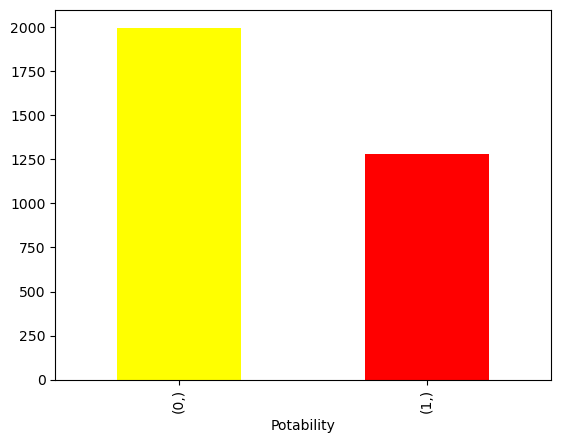

In [17]:
df.iloc[:, -1:].value_counts().plot.bar(color=['yellow', 'red'])

# Feature Engineering
Now we should have some basic understanding about the water potability dataset. Next, let's process the raw dataset and construct input data X and label/output y for logistic regression model training.

In [18]:
x = df.drop("Potability",axis=1)
y = df.Potability

In [19]:
scaler = MinMaxScaler()
X = scaler.fit_transform(x)

# Train logistic regression models
First, let's split the dataset into a training and a testing dataset. Training dataset will be used to train and (maybe) tune models, and testing dataset will be used to evaluate the models.

In [20]:
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 312 )

In [21]:
print(f"Training dataset shape X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing dataset shape X_test: {X_test.shape}, y_test: {y_test.shape}")

Training dataset shape X_train: (2620, 9), y_train: (2620,)
Testing dataset shape X_test: (656, 9), y_test: (656,)


We can train the model because we have an equal distribution of data in both the train and test sets.

In [22]:
model = LogisticRegression()

In [23]:
param_dist = {
    'C': loguniform(1e-5, 100),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']
}

In [24]:
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=100, cv=5)

In [25]:
random_search.fit(X, y)

C:\anakonda\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
225 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\anakonda\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\anakonda\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\anakonda\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002057D0A6410>,
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'saga']})

In [26]:
print("Best Parametres:", random_search.best_params_)

Best Parametres: {'C': 0.8045051150589798, 'penalty': 'l2', 'solver': 'liblinear'}


In [27]:
l1_model = LogisticRegression(penalty ="l1",solver ="liblinear", random_state=312, max_iter=1000)

In [28]:
l1_model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, penalty='l1', random_state=312,
                   solver='liblinear')

In [29]:
l1_pred = l1_model.predict(X_test)

In [30]:
print(classification_report(y_test,l1_pred))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76       400
           1       0.00      0.00      0.00       256

    accuracy                           0.61       656
   macro avg       0.30      0.50      0.38       656
weighted avg       0.37      0.61      0.46       656



C:\anakonda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anakonda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anakonda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
l2_model = LogisticRegression(penalty="l2",solver ="lbfgs",max_iter = 1000,random_state=312)

In [32]:
l2_model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, random_state=312)

In [33]:
l2_pred = l2_model.predict(X_test)

In [34]:
print(classification_report(y_test,l2_pred))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76       400
           1       0.00      0.00      0.00       256

    accuracy                           0.61       656
   macro avg       0.30      0.50      0.38       656
weighted avg       0.37      0.61      0.46       656



C:\anakonda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anakonda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anakonda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## KNN Models Score

In [35]:
knn_model = KNeighborsClassifier(n_neighbors=3)

In [36]:
knn_model.fit(X_train,y_train.values.ravel())

KNeighborsClassifier(n_neighbors=3)

In [37]:
knn_pred=knn_model.predict(X_test)

In [38]:
print(classification_report(y_test,knn_pred))

              precision    recall  f1-score   support

           0       0.66      0.71      0.68       400
           1       0.48      0.43      0.46       256

    accuracy                           0.60       656
   macro avg       0.57      0.57      0.57       656
weighted avg       0.59      0.60      0.59       656



## SVM Models Score


In [39]:
from sklearn.svm import SVC

In [40]:
svm_model = SVC(C=15, kernel ="rbf")
svm_model.fit(X_train,y_train.values.ravel())

SVC(C=15)

In [41]:
svm_pred = svm_model.predict(X_test)

In [42]:
print(classification_report(y_test,svm_pred))

              precision    recall  f1-score   support

           0       0.68      0.83      0.75       400
           1       0.59      0.38      0.46       256

    accuracy                           0.66       656
   macro avg       0.63      0.61      0.61       656
weighted avg       0.64      0.66      0.64       656



## Decision Tree Model Score

In [43]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=3, random_state=312)

In [44]:
tree_model.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=3,
                       random_state=312)

In [45]:
tree_pred = tree_model.predict(X_test)

In [46]:
print(classification_report(y_test,tree_pred))

              precision    recall  f1-score   support

           0       0.62      0.94      0.75       400
           1       0.54      0.12      0.20       256

    accuracy                           0.62       656
   macro avg       0.58      0.53      0.47       656
weighted avg       0.59      0.62      0.53       656



## XGB Boost Model Score

In [47]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [48]:
from xgboost import XGBClassifier 
xgb_model = XGBClassifier(objective="multi:softmax", num_class=len(set(y)))

In [49]:
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=2,
              num_parallel_tree=None, ...)

In [50]:
xgb_pred = xgb_model.predict(X_test)

In [51]:
print(classification_report(y_test,xgb_pred))

              precision    recall  f1-score   support

           0       0.67      0.76      0.71       400
           1       0.52      0.42      0.47       256

    accuracy                           0.62       656
   macro avg       0.60      0.59      0.59       656
weighted avg       0.61      0.62      0.62       656

